In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import tarfile
# from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# dataset_url = "http://files.fast.ai/data/examples/cifar10.tgz"
# download_url(dataset_url, '.')

In [ ]:
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path = './data')

In [ ]:
classes = os.listdir('data/cifar10/train')
classes

In [2]:
data_dir = './data/cifar10'

dataset = ImageFolder(data_dir + '/train', transform = ToTensor())

In [3]:
batch_size = 128
t_s = int(len(dataset)*0.8)
v_s = int(len(dataset) - t_s)
train_ds, val_ds = random_split(dataset, [t_s, v_s])
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True)

In [5]:
for x,y in train_dl:
    print(y.shape)
    break

torch.Size([128])


# ConvNets

In [6]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    #16,32,32
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    #16,16,16
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    #16,8,8
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    #16,4,4
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    #16,1,1
    nn.Flatten(),
    nn.Linear(16,10)
)

In [7]:
for x,y, in train_dl:
    print(x.shape)
    yb = model(x)
    print(yb.shape)
    print(y.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 10])
torch.Size([128])


In [ ]:
def batch_loss(model, batch, loss_fn, opt=None, metrics=None):
    x, y = batch
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    met = None
    if metrics is not None:
        met = metrics(y_pred, y)
    
    return loss, len(x), met

In [ ]:
def evaluate(model, val_dl, loss_fn, metrics=None):
    with torch.no_grad():
        losses = 0
        total = 0
        if metrics is not None:
            mets = 0
        for batch in val_dl:
            loss, sz, met = batch_loss(model, batch, loss_fn, metrics=metrics)
            losses+=loss*sz
            total+=sz
            if metrics is not None:
                mets+=met*sz
    return losses/total, mets/total

In [ ]:
def accuracy(y_pred, y):
    _, preds = torch.max(y_pred, dim=1)
    return (torch.sum(preds==y)).item()/len(y)

In [ ]:
def fit(model, train_dl, val_dl, epochs, loss_fn, lr, opt_fn=torch.optim.Adam, metrics=None):
    opt = opt_fn(model.parameters(), lr = lr)
    
    for epoch in range(epochs):
        model.train()
        for batch in train_dl:
            batch_loss(model, batch, loss_fn, opt, metrics)
        
        model.eval()
        loss, mets = evaluate(model, val_dl, loss_fn, metrics)
        print(f'Epoch {epoch+1}/{epochs} :\nLoss: {loss}  {metrics.__name__}: {mets}')

In [ ]:
fit(model, train_dl, val_dl, 5, F.cross_entropy, 0.005, metrics = accuracy)

In [26]:
test_ds = ImageFolder(data_dir + '/test', transform = ToTensor())

# def predict(img, classes):
#     img = img.unsqueeze(0)
#     yb = model(img)
#     _, preds = torch.max(yb, dim=0)
#     return classes[preds[0].item()]

# img, label = test_ds[8755]
# plt.imshow(img.permute(1,2,0))
# print(predict(img, dataset.classes))
# print(dataset.classes[label])

Failure training!
55% acc(false), with only airplane as predicted

# ResNets

hopefully get betters results.
Will be using test set as validation set for more training data, sorry ://

In [2]:
data_dir = './data/cifar10'

# will find later, ((mean_r),(mean_g),(mean_b)),((stdev_r),(stdev_g),(stdev_b))
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [3]:
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode = 'reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])

val_tfms = tt.Compose([tt.ToTensor(),
                       tt.Normalize(*stats)])

In [4]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
val_ds = ImageFolder(data_dir + '/test', val_tfms)

In [5]:
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle = True,
                      num_workers = 8, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, shuffle = True,
                    num_workers = 8, pin_memory = True)

## making the WideResNet (general)

In [6]:
def conv2d(ni, nf, stride=1, k_s=3):
    return nn.Conv2d(ni, nf, kernel_size = k_s, stride = stride, padding = k_s//2)

In [7]:
def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni),
                         nn.ReLU(inplace=True),
                         conv2d(ni, nf))

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf,nf)
        self.shortcut = lambda x:x
        if ni != nf:
            self.shortcut = conv2d(ni, nf, stride, 1)
            
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        y = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add(y)
        

In [9]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    end = [ResidualBlock(nf,nf) for _ in range(1,N)]
    return [start] + end

In [10]:
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [11]:
class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()
        layers = [conv2d(3, n_start)]
        n_channels = [n_start]
        
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], n_channels[i+1], stride)
            
        layers += [nn.BatchNorm2d(n_channels[-1]),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   Flatten(),
                   nn.Linear(n_channels[-1], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.features(x)

In [12]:
def wrn_22():
    return WideResNet(3, 2, 10, 6)

In [13]:
model = wrn_22()

In [14]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, k

In [55]:
model.load_state_dict(torch.load('WRN_22.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [56]:
img, label = val_ds[6578]
y = model(img.unsqueeze(0))
y

tensor([[-4.9534, -4.9738, -4.3437, -3.0710, -5.0124, -3.6364, -5.1273, -5.2035,
         -6.4251, -4.9235]], grad_fn=<AddmmBackward>)

In [53]:
a, b = torch.max(F.softmax(y, dim=1), dim=0)
print(a)
print(b)

tensor([0.0557, 0.0546, 0.1025, 0.3661, 0.0525, 0.2080, 0.0468, 0.0434, 0.0128,
        0.0574], grad_fn=<MaxBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [54]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, k

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


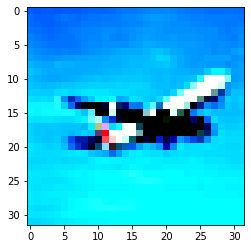

In [20]:
plt.imshow(img.permute(1,2,0))

In [21]:
y.shape

torch.Size([1, 10])

In [35]:
def pred(img):
    img = img.unsqueeze(0)
    yb = model(img)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

pred(img)

3

In [31]:
img, lab = test_ds[0]
img

tensor([[[0.1569, 0.1804, 0.1647,  ..., 0.0980, 0.0863, 0.0824],
         [0.1843, 0.1961, 0.1608,  ..., 0.0941, 0.0824, 0.0863],
         [0.2078, 0.2000, 0.1725,  ..., 0.0902, 0.0824, 0.0902],
         ...,
         [0.0706, 0.1020, 0.1294,  ..., 0.1882, 0.1647, 0.1647],
         [0.0784, 0.1176, 0.1294,  ..., 0.1647, 0.1647, 0.1608],
         [0.0824, 0.0902, 0.0902,  ..., 0.1490, 0.1490, 0.1490]],

        [[0.1882, 0.2118, 0.2000,  ..., 0.1529, 0.1412, 0.1412],
         [0.2000, 0.2235, 0.1961,  ..., 0.1490, 0.1373, 0.1333],
         [0.2157, 0.2275, 0.2078,  ..., 0.1451, 0.1333, 0.1255],
         ...,
         [0.0902, 0.1294, 0.1725,  ..., 0.2235, 0.2039, 0.2118],
         [0.0980, 0.1490, 0.1725,  ..., 0.1961, 0.2000, 0.2039],
         [0.1020, 0.1255, 0.1294,  ..., 0.1882, 0.1882, 0.1882]],

        [[0.1843, 0.2157, 0.1843,  ..., 0.1569, 0.1412, 0.1294],
         [0.1922, 0.2275, 0.1765,  ..., 0.1529, 0.1373, 0.1255],
         [0.2039, 0.2275, 0.1882,  ..., 0.1490, 0.1373, 0.

In [17]:
import fastai

In [18]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [19]:
data = DataBunch.create(train_ds, val_ds, bs=batch_size, path = data_dir)
learner = Learner(data, model, loss_func = F.cross_entropy, metrics= [accuracy])
learner.clip = 0.1

In [20]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

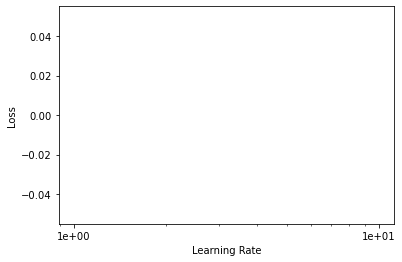

In [22]:
learner.recorder.plot()

In [ ]:
learner.fit_one